In [1]:
import torchvision.transforms
import source.data
import source.utils
import torch.hub
import torch.utils.data
import torch
import torch.optim
import source.modules

import torchvision.models.segmentation
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
_  = torch.manual_seed(0)

cpu_device = torch.device('cpu')
device = torch.device('cuda:0')

torch.cuda.empty_cache()

In [8]:
from source.constants import REPOSITORY_ROOT
checkpoint = torch.load(f"{REPOSITORY_ROOT}/checkpoints/resnet101_long.pth")
model = torchvision.models.segmentation.fcn_resnet101(progress=False)

classifier = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=2048, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
    torch.nn.BatchNorm2d(num_features=512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.1, inplace=False),
    torch.nn.Conv2d(512, 7, kernel_size=(1, 1), stride=(1, 1))
)

model.classifier = classifier
model.aux_classifier = torch.nn.Identity()
image_transform = torchvision.transforms.Compose(
    [
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((336, 448)),
    torchvision.transforms.PILToTensor(),
    torchvision.transforms.Lambda(lambda image_as_int_tensor: image_as_int_tensor / 255.),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
mask_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((336, 448)),
    torchvision.transforms.PILToTensor(),
    torchvision.transforms.Lambda(
        lambda mask_as_int_tensor: mask_as_int_tensor.squeeze().type(torch.LongTensor)
    ),
])


dataset = source.data.AugmentedPascalPartDataset(
    transform=image_transform,
    target_transform=mask_transform
)


model.load_state_dict(checkpoint['model'])
metrics_tracker = checkpoint['training_loss']
evaluation_loss =  checkpoint['evaluation_metrics']

/tmp/ipykernel_2328/3847989875.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"{REPOSITORY_ROOT}/checkpoints/resnet101_long.pth")


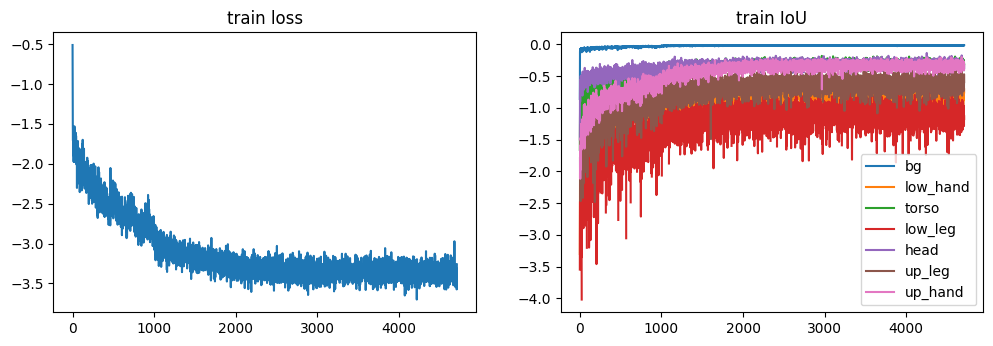

In [9]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(12, 8))

figure.add_subplot(2, 2, 1)
plt.plot(torch.log(torch.tensor(metrics_tracker[-1])).unfold(0, 10, 10).mean(1))
plt.title("train loss")

figure.add_subplot(2, 2, 2)
[
    plt.plot(
        torch.log(torch.tensor(metrics_tracker[index])).unfold(0, 10, 10).mean(1),
        label=dataset.class_to_name[index]
    )
    for index in range(0, 7)
]
plt.legend()
plt.title("train IoU")

plt.show()

In [12]:
print(
    "IoU - ",
    *[
        f"{dataset.class_to_name[object_class]} : " +
        f"{sum(evaluation_loss[object_class]) / len(evaluation_loss[object_class]):.3f} \t "
        for object_class in list(dataset.class_to_name.keys())
    ],
    f"upper_body: {sum(evaluation_loss[7]) / len(evaluation_loss[7]):.3f} \t ",
    f"lower_body: {sum(evaluation_loss[8]) / len(evaluation_loss[8]):.3f} \t ",
    f"body: {sum(evaluation_loss[9]) / len(evaluation_loss[9]):.3f} \t ",
)

IoU -  bg : 0.942 	  low_hand : 0.420 	  torso : 0.589 	  low_leg : 0.343 	  head : 0.723 	  up_leg : 0.387 	  up_hand : 0.477 	  upper_body: 0.319 	  lower_body: 0.435 	  body: 0.734 	 
